<base target="_blank">

*This article is part of our series about how different types of data scientists build similar models differently. No human is the same and therefore also no data scientist is the same. And the circumstances under which a data challenge needs to be handled change constantly. For these reasons, different approaches can and will be used to complete the task at hand. In our series we will explore the four different approaches of our data scientists - Meta Oric, Aki Razzi, Andy Stand, and Eqaan Librium. They are presented with the task to build a model to predict whether employees of a company - STARDATAPEPS - will look for a new job or not. Based on their distinct profiles discussed in the <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-introducing-our-data-science-rock-stars" target="_blank" rel="noopener noreferrer">first blog</a> you can already imagine that their approaches will be quite different.*

*In this article we will look into how to deal with one of the data preparation steps - categorical variables. We will compare default one-hot-encoding with several alternatives: Label Encoding, Frequency Encoding, Weight of Evidence, Smooth Weight of Evidence, Optimal Binning, Hand-picked Binning and Deletion. Finally, Andy and Eqaan will decide which of the techniques they would prefer in their analysis.*

In the previous article, we saw how Meta and Aki built predictive models. Meta focused on minimising the time she spent on this project. She chose a model that is both powerful and requires little to no attention to data preparation. Aki took her model one step further and also tuned hyperparameters to achieve an uplift in the accuracy of the predictions. In this article we will see how Eqaan and Andy will tackle this problem. For explainability and business reasons they prefer to use a logistics model to predict employee churn. This requires a more extensive data preparation than what we saw in the previous articles. But how they will go about it will obviously differ.

### Andy Stand : *'Understand is what we do'* 

!['Andy Stand'](https://bhciaaablob.blob.core.windows.net/featureengineeringreeks/characters/Andy%20Stand_400px.png)

Andy praises himself for being able to explain everything that he does to the business. He never uses black-box techniques and thus will only use methods that can be easily understood by those without a technical background. Thus, some of the more sophisticated techniques that we will look at today, he will not consider for his model.

### Eqaan Librium: 'Equilibrium and work-life balance'###

!['Eqaan Librium'](https://bhciaaablob.blob.core.windows.net/featureengineeringreeks/characters/Equaan%20Librium_400px.png)

Eqaan strives to achieve a balance between the predictive power of his model and the explainability of techniques, thus he will not shy away from using a more complicated method if it gives him a better model.

### Dealing with categorical variables
One of the most common preparation steps is dealing with categorical variables. Various techniques can be used to translate them to a numeric equivalent. These can then be used as features in a predictive model. You saw, that Meta also used encoding in order to prepare all categorical variables. However, she did it in a very rudimental way. She used the same technique on all her variables without taking a second look at what those variables are. Namely, she used one-hot encoding to convert all her categorical variables.

One-hot encoding is a very popular technique. It is also the one that most encounter the first time they try to build the mother of all predictive models -  a simple linear/logistic regression. One-hot encoding is a technique for dealing with nominal variables (or where the ordering can be ignored) where an old variable gets replaced by as many variables as there are categories and each category is represented in a binary manner. However, it is not the only option available when dealing with categorical data, and in some cases not at all useful.

### High cardinality variables
One particular case where one-hot encoding becomes suboptimal is in dealing with variables that have high cardinality. These are variables that have many different values. Then, creating an individual variable for every single value that exists can lead to a substantial increase in the size of the dataset, problems in estimating parameters or even infinite log values. Result would be a model that is difficult to generalize on a new set. Not to mention, that explaining such results can also prove to be a struggle. In our dataset, the variable *city* is a perfect example of a high cardinality. It has 123 unique values.

In [ ]:
# install the package optimal binning
%pip install optbinning

import warnings 
warnings.filterwarnings(action= 'ignore')

In [ ]:
#importing libraries:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve

# use optimal binning
from optbinning import OptimalBinning

import warnings 
warnings.filterwarnings(action= 'ignore')


Although, when you look at the spread of values in mode detail, you can notice that some are more frequent than the others. This is of course very normal for a variable like city. While cities can house millions of people small towns will only have a few thousands inhabitants. Thus, larger cities will also be more frequent in our data. 
As you can see from the graph below, the variable *city name* has a lot of different categories. One-hot encoding results would be very inconvenient.

In [ ]:
df_prep = pd.read_csv('https://bhciaaablob.blob.core.windows.net/featurenegineeringfiles/df_prepared.csv')
df = df_prep.drop(columns=['Unnamed: 0','city', 'experience', 'enrollee_id']) 

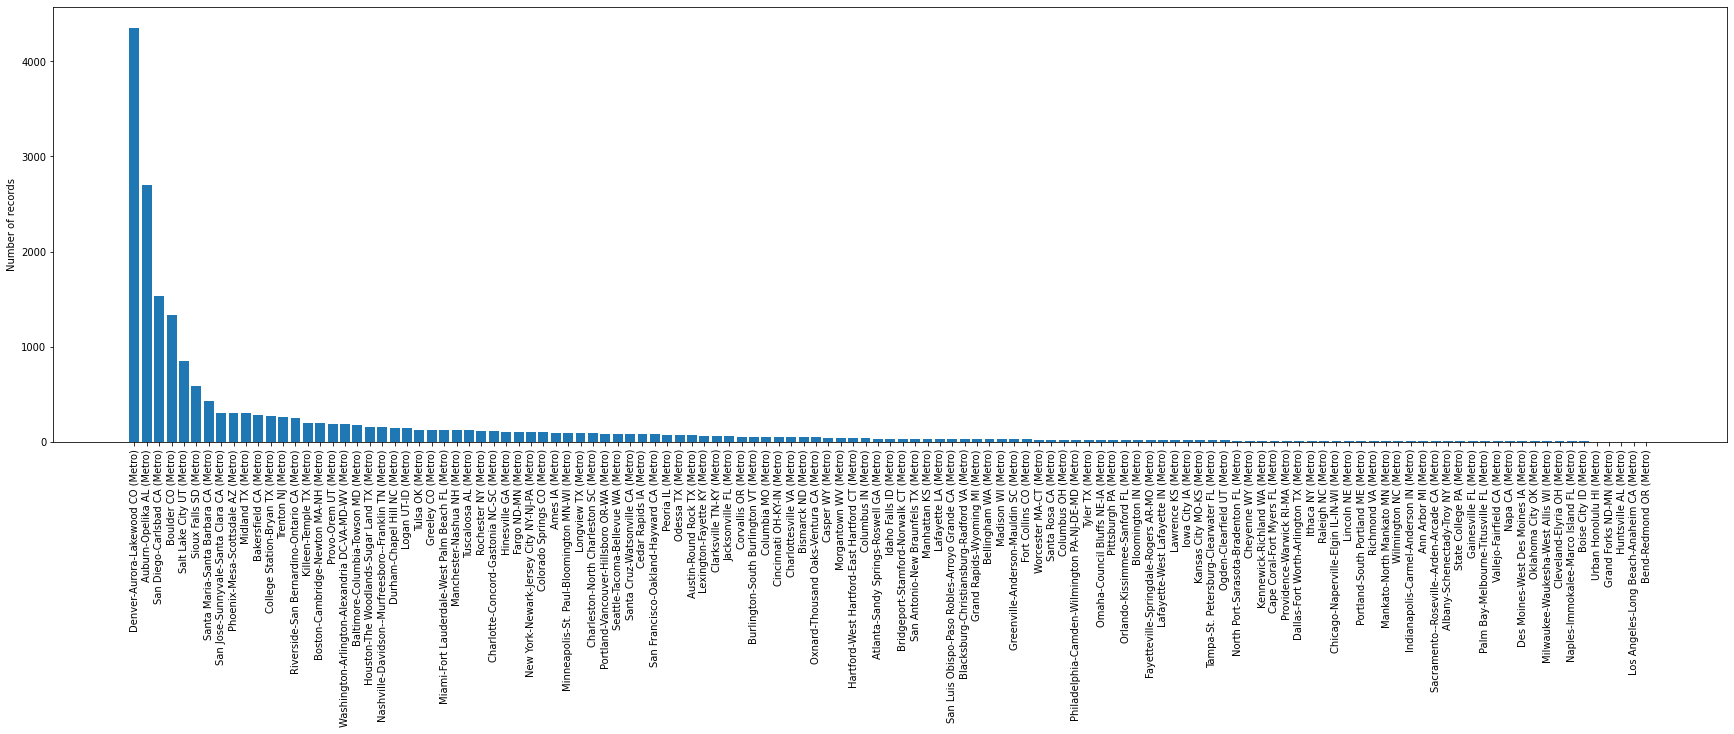

In [ ]:
plt.rcParams['figure.figsize'] = [30, 8]
plt.bar(df['city name'].value_counts().index, df['city name'].value_counts())
plt.ylabel('Number of records')
plt.xticks(rotation=90)
plt.show()

### Data preprocessing
Before we can move to building out benchmark model, we will need to pre-process the data for a logit model. Below you can see what the data looks like. We have mix of categorical and numerical variables. These of course should be dealt separately.

In [ ]:
df.head()

Out[4]:

city_development_index 
 gender 
 enrolled_university 
 education_level 
 major_discipline 
 company_size 
 company_type 
 last_new_job 
 training_hours 
 target 
 ind_relevent_experience 
 experience_num 
 city name 
 
 
 
 
 0 
 0.920 
 Male 
 no_enrollment 
 Graduate 
 STEM 
 NaN 
 NaN 
 1 
 36 
 1 
 1 
 22.0 
 Denver-Aurora-Lakewood CO (Metro) 
 
 
 1 
 0.776 
 Male 
 no_enrollment 
 Graduate 
 STEM 
 50-99 
 Pvt Ltd 
 >4 
 47 
 0 
 0 
 15.0 
 Odessa TX (Metro) 
 
 
 2 
 0.624 
 NaN 
 Full time course 
 Graduate 
 STEM 
 NaN 
 NaN 
 never 
 83 
 0 
 0 
 5.0 
 Auburn-Opelika AL (Metro) 
 
 
 3 
 0.789 
 NaN 
 NaN 
 Graduate 
 Business Degree 
 NaN 
 Pvt Ltd 
 never 
 52 
 1 
 0 
 0.0 
 Corvallis OR (Metro) 
 
 
 4 
 0.767 
 Male 
 no_enrollment 
 Masters 
 STEM 
 50-99 
 Funded Startup 
 4 
 8 
 0 
 1 
 22.0 
 Tulsa OK (Metro)

In [ ]:
# Define the target vector y
y = df['target']  

# Creating a dataset without the DV and the variable city name:
X = df.drop(['target', 'city name'], axis = 1)


# Creating an object with the column labels of only the categorical features and one with only the numeric features:
categorical_features = X.select_dtypes(exclude="number").columns.tolist()
numeric_features = X.select_dtypes(include="number").columns.tolist()

#Categorical variables
X[categorical_features] = X[categorical_features].fillna(X.mode())
one_hot_encode = OneHotEncoder(sparse=False)
one_hot_df = pd.DataFrame(one_hot_encode.fit_transform(X[categorical_features]))
one_hot_df.columns = one_hot_encode.get_feature_names(categorical_features)
    
#Numerical variables 
X[numeric_features] = X[numeric_features].fillna(X.mean())
scaler_encode = StandardScaler()
scaler_encode_df = pd.DataFrame(scaler_encode.fit_transform(X[numeric_features]))
scaler_encode_df.columns = X[numeric_features].columns                                                        

#put X back together and add the city variable
X_prep = scaler_encode_df.join(one_hot_df)
X_prep['city name'] = df['city name']

With the code above we treated all categorical variables by imputing missing values with a mode value and then applying a one-hot encoding technique to all variables except the *city name*. Missingness in a variable can also be interpreted as extra information and thus considered as a category of its own. When it comes to the numeric variables, we firstly imputed all missing values using the mean and then standardized them. You can inspect the resulting data frame below.

In [ ]:
X_prep.head()

Out[6]:

city_development_index 
 training_hours 
 ind_relevent_experience 
 experience_num 
 gender_Female 
 gender_Male 
 gender_Other 
 gender_nan 
 enrolled_university_Full time course 
 enrolled_university_Part time course 
 enrolled_university_no_enrollment 
 enrolled_university_nan 
 education_level_Graduate 
 education_level_High School 
 education_level_Masters 
 education_level_Phd 
 education_level_Primary School 
 education_level_nan 
 major_discipline_Arts 
 major_discipline_Business Degree 
 major_discipline_Humanities 
 major_discipline_No Major 
 major_discipline_Other 
 major_discipline_STEM 
 major_discipline_nan 
 company_size_10/49 
 company_size_100-500 
 company_size_1000-4999 
 company_size_10000+ 
 company_size_50-99 
 company_size_500-999 
 company_size_5000-9999 
 company_size_<10 
 company_size_nan 
 company_type_Early Stage Startup 
 company_type_Funded Startup 
 company_type_NGO 
 company_type_Other 
 company_type_Public Sector 
 company_type_Pvt Ltd 
 company_type_nan 
 last_new_job_1 
 last_new_job_2 
 last_new_job_3 
 last_new_job_4 
 last_new_job_>4 
 last_new_job_never 
 last_new_job_nan 
 city name 
 
 
 
 
 0 
 0.738919 
 -0.488985 
 0.623752 
 1.664375 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 Denver-Aurora-Lakewood CO (Metro) 
 
 
 1 
 -0.428410 
 -0.305825 
 -1.603202 
 0.670951 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 Odessa TX (Metro) 
 
 
 2 
 -1.660590 
 0.293607 
 -1.603202 
 -0.748224 
 0.0 
 0.0 
 0.0 
 1.0 
 1.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 Auburn-Opelika AL (Metro) 
 
 
 3 
 -0.323026 
 -0.222571 
 -1.603202 
 -1.457812 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 1.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 Corvallis OR (Metro) 
 
 
 4 
 -0.501368 
 -0.955209 
 0.623752 
 1.664375 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 Tulsa OK (Metro)

### One-hot encoding
For the base model we decided to use one-hot encoding, since this would be the default option for many data scientists. As we mentioned above, the idea behind it, is that every value in an original variable becomes a variable in it's own right where a value of 1 would indicate belonging to a category. Here is how you can train and evaluate it.

In [ ]:
#one-hot encoding city: 
enc_city = pd.get_dummies(df['city name'])

#Merge the dummmies to the df:
df_dummy = X_prep.drop('city name', axis = 1).join(enc_city)

# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(df_dummy,y,test_size=0.20,random_state=42)

# Instantiate the model (using the default parameters)
logreg = LogisticRegression()
 
# Fit the model with data
logreg.fit(X_train,y_train)

#Predict:
y_pred_dummy=logreg.predict(X_test)
y_pred_proba_dummy = logreg.predict_proba(X_test)[::,1]

# Evaluate the model with the use of cv:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(logreg, X_test, y_test, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))

roc_auc = 0.789883 (0.019211)

This approach gave us a very decent roc auc score of 0.7899. Though, maybe we can do better with other methods?

There are many techniques out there to compete with the one-hot encoding. Thus, both Equaan and Andy had enough to choose from. In this article we will explore the following: 

1. Label Encoding
1. Frequency Encoding
1. Weight of Evidence
1. Smooth Weight of Evidence
1. Optimal Binning
1. Hand-picked Binning
1. Deletion

In the end we will compare these and both Andy and Eqaan will share their thoughts on which ones they will choose for this analysis.

### Label Encoding
Label encoding is a technique where each value is assigned an integer and a resulting variable is used in the analysis. The downside of this approach, is that it gives an illusion of a ranking between the categories. In other words if New York is assigned 1 and Boston 2 than it appear that Boston is lager/bigger/more something than New York, when in reality this relationship does not exist. Thus, it is better suited to ordinal rather than nominal variables. Nevertheless, we will check if this method will provide us with a better model in the end.

In [ ]:
le = LabelEncoder()

#label encoding city: 
enc_city = le.fit_transform(df['city name'])

#Merge the dummmies to the df:
df_label = X_prep.drop('city name', axis = 1)
df_label['city_enc'] = enc_city

# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(df_label,y,test_size=0.20,random_state=42)

# Instantiate the model (using the default parameters)
logreg = LogisticRegression()
 
# Fit the model with data
logreg.fit(X_train,y_train)

#Predict:
y_pred_dummy=logreg.predict(X_test)
y_pred_proba_dummy = logreg.predict_proba(X_test)[::,1]

# Evaluate the model with the use of cv on the test dataset:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(logreg, X_test, y_test, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))

roc_auc = 0.787011 (0.015378)

Label encoding performed a little worse than the dummy coding. Although the difference is actually very small, this technique should definitely not be used for encoding our variable, since city name is not an ordinal variable. By encoding it with this method we create an ordering that does not exist in the data.

### Frequency Encoding
Another interesting approach is to use the information about how frequent the value appears in the dataset as information. Thus, we create a frequency count table related to the high cardinality variable and then calculate what percentage of records have a particular value. You can also read about this method [here](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02#:~:text=name%20is%20BinaryEncoder.-,Frequency%20Encoding,the%20nature%20of%20the%20data). This approach, obviously results in values between 0 and 1. In the cell below you can see the first 5 rows from such an encoding. Since the technique is very easy to understand Andy was particularly happy to try it in a regression.

In [ ]:
df_fe = X_prep.groupby('city name').size()/len(X_prep)
d = pd.DataFrame()
d['Temp_freq_encode'] = X_prep['city name'].map(df_fe)
d['city name'] = X_prep['city name']
d.head()

Out[9]:

Temp_freq_encode 
 city name 
 
 
 
 
 0 
 0.227320 
 Denver-Aurora-Lakewood CO (Metro) 
 
 
 1 
 0.003549 
 Odessa TX (Metro) 
 
 
 2 
 0.141038 
 Auburn-Opelika AL (Metro) 
 
 
 3 
 0.002819 
 Corvallis OR (Metro) 
 
 
 4 
 0.006681 
 Tulsa OK (Metro)

In [ ]:
#Merge the encoded variable to the df:
df_fe = X_prep.drop('city name', axis = 1)
df_fe['city_enc'] = d['Temp_freq_encode']

# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(df_fe,y,test_size=0.20,random_state=42)

# Instantiate the model (using the default parameters)
logreg = LogisticRegression()
 
# Fit the model with data
logreg.fit(X_train,y_train)

#Predict:
y_pred_dummy=logreg.predict(X_test)
y_pred_proba_dummy = logreg.predict_proba(X_test)[::,1]

# Evaluate the model with the use of cv on the test dataset:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(logreg, X_test, y_test, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))



roc_auc = 0.793895 (0.016094)

Well, isn't this a nice result! Frequency encoding managed to beat our base model (0.794 vs. 0.7899). Although the difference is not drastic, incorporating information about how frequent the value appears in the data leads to an improved AUC score. This technique is also very easy to explain, thus making it a good contender for Andy's final solution.

### Encoding with Weight of Evidence (WoE)
Weight of Evidence (WOE) measures the “strength” of variable in relation to the target. The weight is evidence of how well the 'events' and 'non-events' can be separated from each other. For a categorical variable you can calculate the WOE for each categorical value. All WOE's together form one new numerical variable calculated in the following manner:


$$WOE = ln (\frac{NumberOfEvents}{NumberOfNonevents})$$

This value will be positive if the percentage of events is higher than the percentage of non-events and hence negative if the percentage of events is smaller than that of the non-events.  In fact the weight of evidence shows how much a value supports or undermined the hypothesis.  
After calculating the WOE value for each separate group, we map it back to the original data and then use as a variable in our model.

This approach creates a variable that is already transformed onto a 'logistic' scale thus improving the model. More on this approach can be found in [this great overview](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html).

In [ ]:
def calcWoes(df, catvar, target):
    rho = df[target].mean()
    c = 25
    logit = np.log(rho/(1.0-rho)) # mean logit
    catvalues = df[catvar].unique()

    # initialise my dataframe
    Woe_frame = pd.DataFrame()

    # calculate Woes
    for catvalue in catvalues:
        n = df.loc[(df[catvar] == catvalue)][target].count()
        n_nonevents = df.loc[(df[catvar] == catvalue) & (df[target] == 0)][target].count()
        n_events    = df.loc[(df[catvar] == catvalue) & (df[target] == 1)][target].count()
        Woe = np.log(np.maximum(n_events,0.5)/np.maximum(n_nonevents,0.5))
        Woe_frame = Woe_frame.append([[catvalue,Woe]])

    # rename columns
    Woe_frame = Woe_frame.rename(columns={0:catvar,1:'Woe'})
    return (Woe_frame, logit)


def Woe_enrich(df, Woe_frame, logit, catvar):   
    result = pd.merge(df, Woe_frame, on=[catvar], how ='left')
    result.loc[(result['Woe'].isnull()),'Woe'] = logit
    return result

In [ ]:
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X_prep,y,test_size=0.20,random_state=42)
df_woe_train = X_train.join(y_train)
# calculate Woe's
Woe, logit = calcWoes(df_woe_train,'city name', 'target')


# Add encoded variable
df_ver_Woe_train = Woe_enrich(X_train, Woe, logit, 'city name').drop('city name', axis = 1)
df_ver_Woe_test = Woe_enrich(X_test, Woe, logit, 'city name').drop('city name', axis = 1)


# Instantiate the model (using the default parameters)
logreg = LogisticRegression()
 
# Fit the model with data
logreg.fit(df_ver_Woe_train,y_train)

#Predict:
y_pred_dummy=logreg.predict(df_ver_Woe_test)
y_pred_proba_dummy = logreg.predict_proba(df_ver_Woe_test)[::,1]


# Evaluate the model with the use of cv on the test dataset:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(logreg, df_ver_Woe_test, y_test, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))


roc_auc = 0.792368 (0.013413)

Not quite as good as the frequency encoding, but a very decent result. Although this technique might not be for Andy, since it is not very interpretable. However, for Equuan it is a definite contender.

### Encoding with Smooth Weight of Evidence (SWoE)
As we have just seen WOE is a great technique. However, it has one major drawback when dealing with the high cardinality variable. Namely, when the number of (non)events in the group is zero or close to zero, the value of WOE will be extremely large or even infinite. This creates unstable solutions.
The trick is to correct for this. There are two ways to do this: 
- You can combine groups with similar WOE. This brings you to optimal binning, which we will look at shorty. 
- You can adjust the WOE or log(odds) by adding a small number of (non)events that reflect the average odds, thus smoothing the proportion of rare to common values. This  Smoothed Weight of Evidence (SWOE) approach is more robust. We are testing it below.

In [ ]:
def calcSwoes(df, catvar, target):
    rho = df[target].mean()
    c = 25
    logit = np.log(rho/(1.0-rho)) # mean logit
    catvalues = df[catvar].unique()

    # initialise my dataframe
    swoe_frame = pd.DataFrame()

    # calculate swoes
    for catvalue in catvalues:
        n = df.loc[(df[catvar] == catvalue)][target].count()
        #c_sub = np.maximum(0, (c - n))
        n_nonevents = df.loc[(df[catvar] == catvalue) & (df[target] == 0)][target].count()
        n_events    = df.loc[(df[catvar] == catvalue) & (df[target] == 1)][target].count()
        swoe = np.log((n_events + (c * rho))/(n_nonevents + (c *(1.0-rho))))
        swoe_frame = swoe_frame.append([[catvalue,swoe]])

    # rename columns
    swoe_frame = swoe_frame.rename(columns={0:catvar,1:'swoe'})
    return (swoe_frame, logit)


def swoe_enrich(df, swoe_frame, logit, catvar):   
    result = pd.merge(df, swoe_frame, on=[catvar], how ='left')
    result.loc[(result['swoe'].isnull()),'swoe'] = logit
    return result


In [ ]:
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X_prep,y,test_size=0.20,random_state=42)
df_swoe_train = X_train.join(y_train)
# calculate Woe's
Woe, logit = calcSwoes(df_swoe_train,'city name', 'target')


# Add encoded variable
df_ver_SWoe_train = swoe_enrich(X_train, Woe, logit, 'city name').drop('city name', axis = 1)
df_ver_SWoe_test = swoe_enrich(X_test, Woe, logit, 'city name').drop('city name', axis = 1)


# Instantiate the model (using the default parameters)
logreg = LogisticRegression()
 
# Fit the model with data
logreg.fit(df_ver_SWoe_train,y_train)

#Predict:
y_pred_dummy=logreg.predict(df_ver_SWoe_test)
y_pred_proba_dummy = logreg.predict_proba(df_ver_SWoe_test)[::,1]


# Evaluate the model with the use of cv on the test dataset:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(logreg, df_ver_SWoe_test, y_test, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))


roc_auc = 0.792714 (0.012734)

Surprisingly, the smooth weight of evidence has actually performed a little bit less than the weight of evidence. But the difference is minute, namely just about 0.001. Thus it looks like these two techniques give an almost identical results in our case.

### Hand-picked binning
One of the most intuitive thing to do, is to try and reduce the cardinality of the variable by hand. The logic behind this approach, is that although individually all the values that appear in the data only once or twice might not carry much information, combining might improve the predictive power. Not to mention this would greatly improve the interpretability, since you no longer have to describe all the individual values. However, the pitfall of this approach is that you will determine yourself exactly where the cut-off is. This can off course make any graph look nice, but the statistical underpinning of such an action is rather vague.

In [ ]:
keep_values = X_prep['city name'].value_counts().loc[X_prep['city name'].value_counts()>50].index

#all cities that are not in the list, combine
def re_code_city(x):
  if x not in(keep_values):
    return 'Combined_city'
  else:
    return x
  

In [ ]:
#recode and attach the new variable
recoded_city = X_prep['city name'].apply(re_code_city)

#one-hot encoding city: 
enc_city = pd.get_dummies(recoded_city)

#Merge the dummmies to the df:
df_label = X_prep.drop(['city name'], axis = 1).join(enc_city)

# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(df_label,y,test_size=0.20,random_state=42)

# Instantiate the model (using the default parameters)
logreg = LogisticRegression()
 
# Fit the model with data
logreg.fit(X_train,y_train)

#Predict:
y_pred_dummy=logreg.predict(X_test)
y_pred_proba_dummy = logreg.predict_proba(X_test)[::,1]

# Evaluate the model with the use of cv:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(logreg, X_test, y_test, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))

roc_auc = 0.790029 (0.019287)

It's difficult to argue, this method is very intuitive and Andy will find it very easy to explain others what he did. However, the result still comes short to our model with the frequency encoding. But maybe, if the binning will be done in a more sophisticated way we could achieve a better result?

### Optimal Binning
Optimal binning is the optimal discretization of a variable into bins given a numeric target. It is a process where values of a  variable are grouped into bins with similar target behavior. This binning is done in such a way to have an optimal relation between the new variable with the bins and target. You can add constraints like number of bins or bin-size. 

Seeing which values 'belong together' could be very helpfull for understanding the relationship between variable and target. Problems like missings values or outliers are eradicated, these are put in one of the bins. The binned variable has a lot less categories, so a lot less dummy variables after hot-encoding.

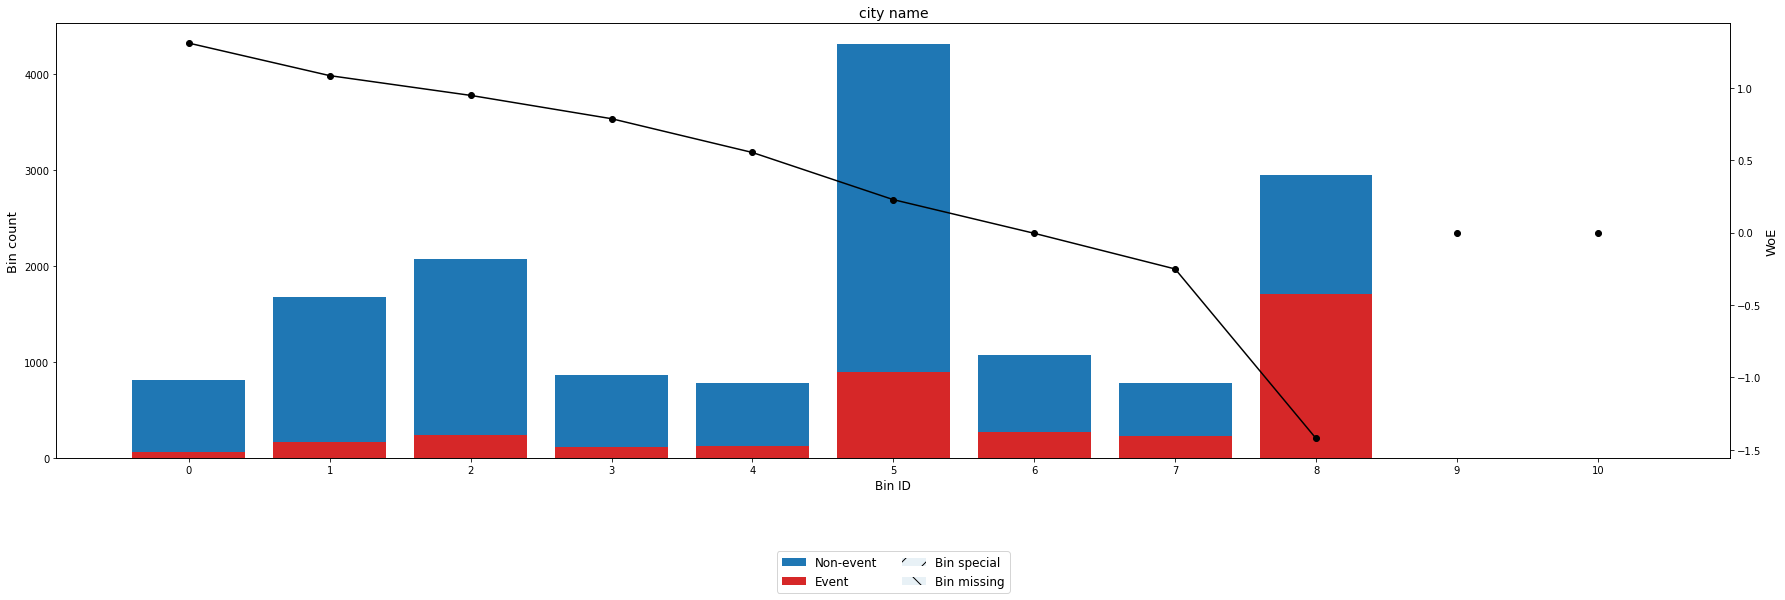

In [ ]:
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X_prep,y,test_size=0.20,random_state=42)

# 1) Define your feature and target arrays
X_var = X_prep['city name']

# 2) Instantiate class and fit to train dataset
optb = OptimalBinning(name='city name', dtype="categorical" ,solver="cp")#oke, min_prebin_size=0.01,max_n_prebins=50,gamma=0) #min_n_bins=3,max_n_bins=3,min_prebin_size=0.05)
optb.fit(X_train['city name'], y_train)

# 3) Show binning table
binning_table = optb.binning_table
binning_table = binning_table.build()

# 4) To perform the binning of a dataset
x_transform_woe = optb.transform(X_var, metric="woe")
X_with_Woe = pd.DataFrame({'city name': X_var, "WoE": x_transform_woe})
# dropping ALL duplicate values
X_with_Woe.drop_duplicates(inplace = True)

X_train_optbin = pd.merge(X_train, X_with_Woe, on=['city name'], how ='left')
X_test_optbin = pd.merge(X_test, X_with_Woe, on=['city name'], how ='left')

# 5) To visualize the results table and plot
optb.binning_table.build()
optb.binning_table.plot(metric="woe")

In [ ]:
# Instantiate the model (using the default parameters)
logreg_optbin = LogisticRegression()

# Fit the model with data
# logreg_optbin.fit(X_train,y_train)

# df.loc[:, df.columns != col]
X_train_optbin2 = X_train_optbin.drop(['city name'], axis = 1)
X_test_optbin2 = X_test_optbin.drop(['city name'], axis = 1)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train_optbin2)
X_train_scaled = scaler.transform(X_train_optbin2)
X_test_scaled = scaler.transform(X_test_optbin2)

# Fit the model with data
logreg_optbin.fit(X_train_scaled,y_train)

#Predict:
y_pred_optbin = logreg_optbin.predict(X_test_scaled)
y_pred_proba_optbin = logreg_optbin.predict_proba(X_test_scaled)[::,1]

#Getting its model coefficients:
#df_model_coef_optbin = pd.DataFrame(logreg_optbin.coef_[0,:], X_train_optbin2.columns)
#print(df_model_coef_optbin)


# Evaluate the model with the use of cv on the test dataset:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(logreg, X_test_optbin2, y_test, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))


roc_auc = 0.792142 (0.012905)

As predicted, this did better than binning categories by hand, however this model is not the best overall!

### Removing the high-cardinality variable
There is also another approach, namely to remove the high cardinality variable altogether. Although this is a very quick solution, we would like to urge you against doing so. The variable could prove to be important for the model that you are trying to build. Removing it would cause you to loose valuable information. However, in our data we already have a variable that carries information regarding a city, namely city development index. So it might be that here it will be an acceptable solution. Obviously, we do not expect to get amazing results using this method.

In [ ]:
#Drop the city name variable altogether
df_drop = X_prep.drop(['city name'], axis = 1)

# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(df_drop,y,test_size=0.20,random_state=42)

# Instantiate the model (using the default parameters)
logreg = LogisticRegression()
 
# Fit the model with data
logreg.fit(X_train,y_train)

#Predict:
y_pred_dummy=logreg.predict(X_test)
y_pred_proba_dummy = logreg.predict_proba(X_test)[::,1]

# Evaluate the model with the use of cv:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(logreg, X_test, y_test, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))


roc_auc = 0.779074 (0.014153)

Unsurprisingly, model fit is worse than that of our baseline. However, the difference is not substantial and if one would have wanted to save some time on data processing, this variable could have been removed

### Now what?
In this article we took a look at different methods for dealing with categorical variables and how they perform in particularly if the variable has high cardinality. Overall we saw that all methods gave very comparable results.

|Method|AUC score|
|----------|-----|
|**Frequency encoding**|0.793895|
|**Smooth Weight of Evidence**|0.792714|
|Weight of Evidence|0.792368|
|Optimal binning|0.792142|
|Hand picked binning|0.790029|
|One-hot encoding|0.789883|
|Label encoding|0.787011|
|Removing the variable|0.779074|

Lets now give the microphone to Andy  and Eqaan, what did they think about all this.

!['Andy Stand'](https://bhciaaablob.blob.core.windows.net/featureengineeringreeks/characters/Andy%20Stand_400px.png)

'I personally would use a frequency encoding to deal with the city name variable. It is very easy to explain. I particularly like that you do not only get a very good model, but also get some more insights into the distribution of the variable itself. Maybe we can even think of some new interventions based on the location of our employees? Perhaps some interesting local events?'

!['Eqaan Librium'](https://bhciaaablob.blob.core.windows.net/featureengineeringreeks/characters/Equaan Librium_400px.png)

'Frequency encoding was a clear winner. I would say that smooth weight of evidence was also a good approach. It performed just a little bit worse. I would also like to add that we see that - except for frequency encoding - the less interpretable techniques performed better than those that Andy would have preferred.'

Overview of links to blogs:
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-introducing-our-data-science-rock-stars" target="_blank" rel="noopener noreferrer">Introducing our data science rock stars</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-data-to-predict-which-employees-are-likely-to-leave" target="_blank" rel="noopener noreferrer">Data to predict which employees are likely to leave</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-good-model-by-default-using-xgboost" target="_blank" rel="noopener noreferrer">Good model by default using XGBoost</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-hyperparameter-tuning-for-hyperaccurate-xgboost-model" target="_blank" rel="noopener noreferrer">Hyperparameter tuning for hyperaccurate XGBoost model</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-beat-dirty-data" target="_blank" rel="noopener noreferrer">Beat dirty data</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-the-case-of-high-cardinality-kerfuffles" target="_blank" rel="noopener noreferrer">The case of high cardinality kerfuffles</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-guide-to-manage-missing-data" target="_blank" rel="noopener noreferrer">Guide to manage missing data</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same-visualise-the-business-value-of-predictive-models" target="_blank" rel="noopener noreferrer">Visualise the business value of predictive models</a>
1. <a href="https://www.theanalyticslab.nl/no-data-scientist-is-the-same" target="_blank" rel="noopener noreferrer">No data scientist is the same!</a>